In [1]:
import torch
import math
torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25                         # tiny data set
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.1 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 3
n_coeffs = 100                        # J  >>  n_data  -> ill conditioned
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):        # Cox-de Boor (recursive)
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

# design matrix  X  (n_data × n_coeffs)
X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze()
X = X.to(device)

# 2-nd-difference operator  D2  ((J-2)×J)
eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

# helper to compute losses
def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

# training loop template -------------------------------------------------
def train(method, epochs=2000, lam=1.0, lr=1e-2, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}                             # extra params (e.g. theta, log λ)
    opt      = None

    # ---- specific pre-conditioning -------------------------------------
    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale           # scaled parameters
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

    elif method == 'DR+adam':
        # thin SVD of D2
        U,S,Vh = torch.linalg.svd(D2)
        Z      = Vh.T[:, 2:]                    # drop null-space
        theta  = torch.zeros(Z.shape[1], device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'Z':Z, 'theta':theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)    # only used for data step
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    # ---- training -------------------------------------------------------
    for e in range(1, epochs+1):
        if method == 'DR+adam':
            beta_curr = extras['Z'] @ extras['theta']
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse      # we handle penalty in closed form

        opt.zero_grad()
        loss_total.backward()

        # gradient step ---------------------------------------------------
        if method == 'prox-ista':
            # data gradient step
            with torch.no_grad():
                beta -= lr * beta.grad
                # proximal solve: (I + lr*λ D^T D)^{-1} beta
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        # reporting -------------------------------------------------------
        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr if method!='DR+adam' else extras['Z'] @ extras['theta'], lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

# ------------------------------------------------------------------------
for m in ['plain-adam', 'jacobi', 'adagrad', 'DR+adam', 'prox-ista']:
    print('\n===', m, '==='); train(m)



=== plain-adam ===
plain-adam | iter    1 | data 4.5553e-01 | penalty 1.3291e-05
plain-adam | iter  200 | data 8.7548e-05 | penalty 2.3424e-04
plain-adam | iter  400 | data 3.8038e-05 | penalty 2.4706e-04
plain-adam | iter  600 | data 3.8035e-05 | penalty 2.4709e-04
plain-adam | iter  800 | data 3.8033e-05 | penalty 2.4726e-04
plain-adam | iter 1000 | data 3.8026e-05 | penalty 2.4752e-04
plain-adam | iter 1200 | data 3.8032e-05 | penalty 2.4795e-04
plain-adam | iter 1400 | data 3.8033e-05 | penalty 2.4704e-04
plain-adam | iter 1600 | data 3.8061e-05 | penalty 2.4755e-04
plain-adam | iter 1800 | data 3.8031e-05 | penalty 2.4708e-04
plain-adam | iter 2000 | data 3.8030e-05 | penalty 2.4734e-04

=== jacobi ===
jacobi     | iter    1 | data 4.6759e-01 | penalty 0.0000e+00
jacobi     | iter  200 | data 2.1922e-01 | penalty 2.7204e-02
jacobi     | iter  400 | data 1.2958e-01 | penalty 3.3429e-02
jacobi     | iter  600 | data 8.4188e-02 | penalty 2.7511e-02
jacobi     | iter  800 | data 5.67

/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_93926/767102273.py:69: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1765.)
  LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))


NameError: name 'trained_betas' is not defined

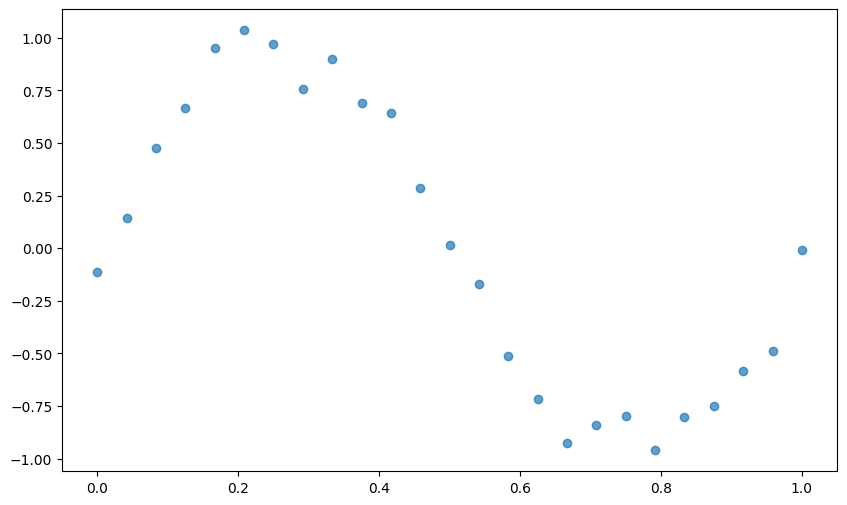

In [3]:
import torch
import math
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

for method, beta_val in trained_betas.items():
    # Compute the basis functions for the dense x_plot
    X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze()
    X_plot = X_plot.to(device)
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method} Learned Function')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.savefig('learned_functions.png')

# Save data for further analysis or plotting if needed


In [12]:
import torch
import math
import matplotlib.pyplot as plt
import pandas as pd
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25                         # tiny data set
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 3
n_coeffs = 100                        # J  >>  n_data  -> ill conditioned
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):        # Cox-de Boor (recursive)
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

# design matrix  X  (n_data × n_coeffs)
X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze()
X = X.to(device)

# 2-nd-difference operator  D2  ((J-2)×J)
eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

# helper to compute losses
def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

# training loop template -------------------------------------------------
trained_betas = {} # Store trained beta values for plotting

def train(method, epochs=1000, lam=100.0, lr=1e-2, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}                             # extra params (e.g. theta, log λ)
    opt      = None

    # ---- specific pre-conditioning -------------------------------------
    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale           # scaled parameters
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

    elif method == 'DR+adam':
        # thin SVD of D2
        # U,S,Vh = torch.linalg.svd(D2)
        # Z      = Vh.T[:, 2:]                    # drop null-space
        # theta  = torch.zeros(Z.shape[1], device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'Z':Z, 'theta':theta})
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)  # drop first 2 components (null space)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4  # eigenvalues of D2^T D2

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)    # only used for data step
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    # ---- training -------------------------------------------------------
    for e in range(1, epochs+1):
        if method == 'DR+adam':
            # beta_curr = extras['Z'] @ extras['theta']
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])  # full DCT spectrum
            beta_curr = dct.idct(beta_dct, norm='ortho')

        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse      # we handle penalty in closed form

        opt.zero_grad()
        loss_total.backward()

        # gradient step ---------------------------------------------------
        if method == 'prox-ista':
            # data gradient step
            with torch.no_grad():
                beta -= lr * beta.grad
                # proximal solve: (I + lr*λ D^T D)^{-1} beta
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        # reporting -------------------------------------------------------
        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                # data_mse, rough, _ = losses(beta_curr if method!='DR+adam' else extras['Z'] @ extras['theta'], lam)
                data_mse, rough, _ = losses(beta_curr, lam)

                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    if method == 'DR+adam':
        trained_betas[method] = (extras['Z'] @ extras['theta']).detach().cpu()
    elif method == 'jacobi':
        trained_betas[method] = (beta / extras['scale']).detach().cpu()
    else:
        trained_betas[method] = beta.detach().cpu()


# ------------------------------------------------------------------------
for m in ['plain-adam', 'jacobi', 'adagrad', 'DR+adam', 'prox-ista']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

for method, beta_val in trained_betas.items():
    # Compute the basis functions for the dense x_plot
    X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze()
    X_plot = X_plot.to(device)
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method} Learned Function')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.savefig('learned_functions.png')


=== plain-adam ===
plain-adam | iter    1 | data 5.9971e-01 | penalty 5.3457e-05
plain-adam | iter  200 | data 7.2691e-02 | penalty 2.3033e-04
plain-adam | iter  400 | data 6.0212e-02 | penalty 2.0775e-04
plain-adam | iter  600 | data 5.8075e-02 | penalty 2.0208e-04
plain-adam | iter  800 | data 5.7637e-02 | penalty 2.0230e-04
plain-adam | iter 1000 | data 5.7553e-02 | penalty 2.0425e-04

=== jacobi ===
jacobi     | iter    1 | data 6.1274e-01 | penalty 0.0000e+00
jacobi     | iter  200 | data nan | penalty nan
jacobi     | iter  400 | data nan | penalty nan
jacobi     | iter  600 | data nan | penalty nan
jacobi     | iter  800 | data nan | penalty nan
jacobi     | iter 1000 | data nan | penalty nan

=== adagrad ===
adagrad    | iter    1 | data 5.9971e-01 | penalty 5.4075e-05
adagrad    | iter  200 | data 4.5022e-01 | penalty 5.6674e-05
adagrad    | iter  400 | data 3.7271e-01 | penalty 7.1420e-05
adagrad    | iter  600 | data 3.1850e-01 | penalty 8.0587e-05
adagrad    | iter  800 | 

KeyError: 'Z'


=== plain-adam ===
plain-adam | iter    1 | data 5.9971e-01 | penalty 9.5182e-06
plain-adam | iter  200 | data 1.9480e-03 | penalty 1.3579e-04
plain-adam | iter  400 | data 1.0484e-04 | penalty 5.9820e-05
plain-adam | iter  600 | data 1.0467e-04 | penalty 4.8317e-05
plain-adam | iter  800 | data 1.0467e-04 | penalty 3.9513e-05
plain-adam | iter 1000 | data 1.0467e-04 | penalty 3.3645e-05
plain-adam | iter 1200 | data 1.0467e-04 | penalty 2.9418e-05
plain-adam | iter 1400 | data 1.0467e-04 | penalty 2.5256e-05
plain-adam | iter 1600 | data 1.0467e-04 | penalty 2.3280e-05
plain-adam | iter 1800 | data 1.0467e-04 | penalty 1.9606e-05
plain-adam | iter 2000 | data 1.0467e-04 | penalty 1.6364e-05
plain-adam | iter 2200 | data 1.0468e-04 | penalty 1.4715e-05
plain-adam | iter 2400 | data 1.0467e-04 | penalty 1.3309e-05
plain-adam | iter 2600 | data 1.0467e-04 | penalty 1.3225e-05
plain-adam | iter 2800 | data 1.0467e-04 | penalty 1.0924e-05
plain-adam | iter 3000 | data 1.0468e-04 | penalty

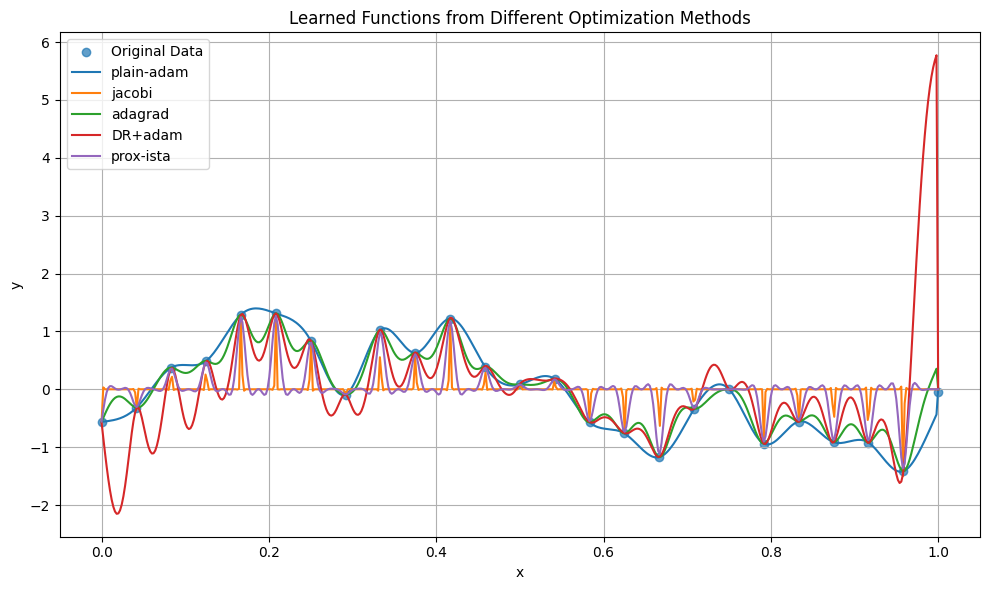

In [4]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=0.1, lr=1e-2, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam', 'jacobi', 'adagrad', 'DR+adam', 'prox-ista']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1272e-01 | penalty 1.5000e-10
plain-adam | iter  200 | data 6.1029e-01 | penalty 5.9729e-06
plain-adam | iter  400 | data 6.0786e-01 | penalty 2.3767e-05
plain-adam | iter  600 | data 6.0544e-01 | penalty 5.3208e-05
plain-adam | iter  800 | data 6.0302e-01 | penalty 9.4137e-05
plain-adam | iter 1000 | data 6.0062e-01 | penalty 1.4641e-04
plain-adam | iter 1200 | data 5.9822e-01 | penalty 2.0990e-04
plain-adam | iter 1400 | data 5.9584e-01 | penalty 2.8449e-04
plain-adam | iter 1600 | data 5.9346e-01 | penalty 3.7007e-04
plain-adam | iter 1800 | data 5.9109e-01 | penalty 4.6656e-04
plain-adam | iter 2000 | data 5.8873e-01 | penalty 5.7387e-04
plain-adam | iter 2200 | data 5.8638e-01 | penalty 6.9193e-04
plain-adam | iter 2400 | data 5.8403e-01 | penalty 8.2067e-04
plain-adam | iter 2600 | data 5.8170e-01 | penalty 9.6003e-04
plain-adam | iter 2800 | data 5.7937e-01 | penalty 1.1100e-03
plain-adam | iter 3000 | data 5.7704e-01 | penalty

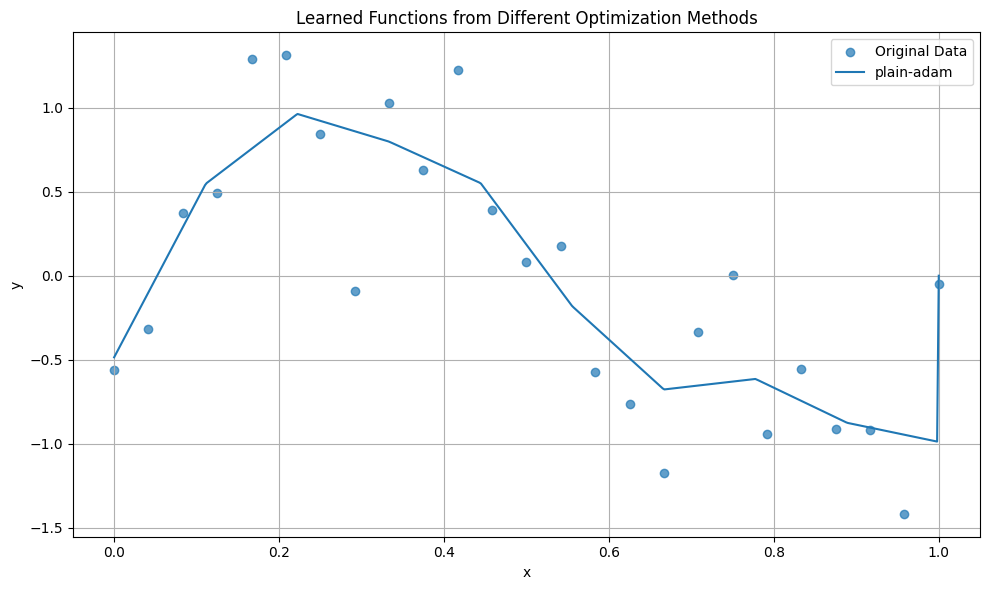

In [9]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 10
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=0.1, lr=1e-5, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1272e-01 | penalty 9.6867e-11
plain-adam | iter  200 | data 6.1012e-01 | penalty 1.6547e-07
plain-adam | iter  400 | data 6.0751e-01 | penalty 6.0205e-07
plain-adam | iter  600 | data 6.0491e-01 | penalty 1.2733e-06
plain-adam | iter  800 | data 6.0232e-01 | penalty 2.1822e-06
plain-adam | iter 1000 | data 5.9974e-01 | penalty 3.3316e-06
plain-adam | iter 1200 | data 5.9718e-01 | penalty 4.7198e-06
plain-adam | iter 1400 | data 5.9462e-01 | penalty 6.3448e-06
plain-adam | iter 1600 | data 5.9207e-01 | penalty 8.2043e-06
plain-adam | iter 1800 | data 5.8953e-01 | penalty 1.0297e-05
plain-adam | iter 2000 | data 5.8700e-01 | penalty 1.2620e-05
plain-adam | iter 2200 | data 5.8447e-01 | penalty 1.5173e-05
plain-adam | iter 2400 | data 5.8196e-01 | penalty 1.7954e-05
plain-adam | iter 2600 | data 5.7945e-01 | penalty 2.0961e-05
plain-adam | iter 2800 | data 5.7695e-01 | penalty 2.4194e-05
plain-adam | iter 3000 | data 5.7446e-01 | penalty

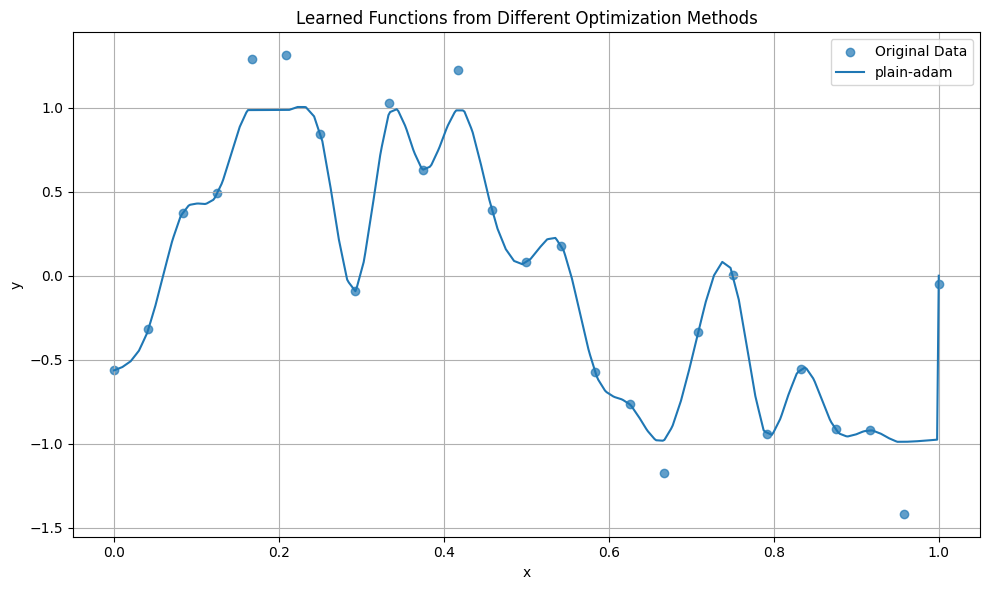

In [11]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 100
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=0.1, lr=1e-5, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1272e-01 | penalty 9.5182e-12
plain-adam | iter  200 | data 6.1012e-01 | penalty 9.6231e-09
plain-adam | iter  400 | data 6.0751e-01 | penalty 2.2279e-08
plain-adam | iter  600 | data 6.0491e-01 | penalty 3.6711e-08
plain-adam | iter  800 | data 6.0232e-01 | penalty 5.2588e-08
plain-adam | iter 1000 | data 5.9974e-01 | penalty 6.9653e-08
plain-adam | iter 1200 | data 5.9718e-01 | penalty 8.7702e-08
plain-adam | iter 1400 | data 5.9462e-01 | penalty 1.0658e-07
plain-adam | iter 1600 | data 5.9207e-01 | penalty 1.2618e-07
plain-adam | iter 1800 | data 5.8953e-01 | penalty 1.4643e-07
plain-adam | iter 2000 | data 5.8700e-01 | penalty 1.6727e-07
plain-adam | iter 2200 | data 5.8447e-01 | penalty 1.8868e-07
plain-adam | iter 2400 | data 5.8196e-01 | penalty 2.1064e-07
plain-adam | iter 2600 | data 5.7945e-01 | penalty 2.3312e-07
plain-adam | iter 2800 | data 5.7695e-01 | penalty 2.5612e-07
plain-adam | iter 3000 | data 5.7446e-01 | penalty

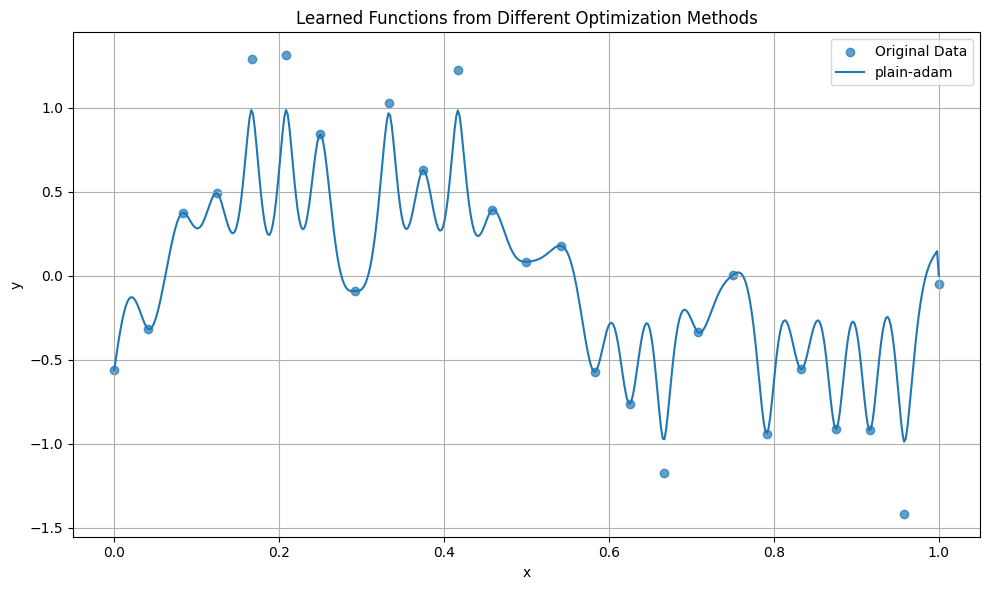

In [12]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=0.1, lr=1e-5, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1260e-01 | penalty 9.5182e-10
plain-adam | iter  200 | data 5.8700e-01 | penalty 1.9988e-07
plain-adam | iter  400 | data 5.6230e-01 | penalty 4.1479e-07
plain-adam | iter  600 | data 5.3858e-01 | penalty 6.4002e-07
plain-adam | iter  800 | data 5.1577e-01 | penalty 8.8283e-07
plain-adam | iter 1000 | data 4.9382e-01 | penalty 1.1433e-06
plain-adam | iter 1200 | data 4.7268e-01 | penalty 1.4190e-06
plain-adam | iter 1400 | data 4.5230e-01 | penalty 1.7073e-06
plain-adam | iter 1600 | data 4.3266e-01 | penalty 2.0053e-06
plain-adam | iter 1800 | data 4.1372e-01 | penalty 2.3105e-06
plain-adam | iter 2000 | data 3.9545e-01 | penalty 2.6208e-06
plain-adam | iter 2200 | data 3.7783e-01 | penalty 2.9343e-06
plain-adam | iter 2400 | data 3.6083e-01 | penalty 3.2495e-06
plain-adam | iter 2600 | data 3.4443e-01 | penalty 3.5651e-06
plain-adam | iter 2800 | data 3.2861e-01 | penalty 3.8801e-06
plain-adam | iter 3000 | data 3.1335e-01 | penalty

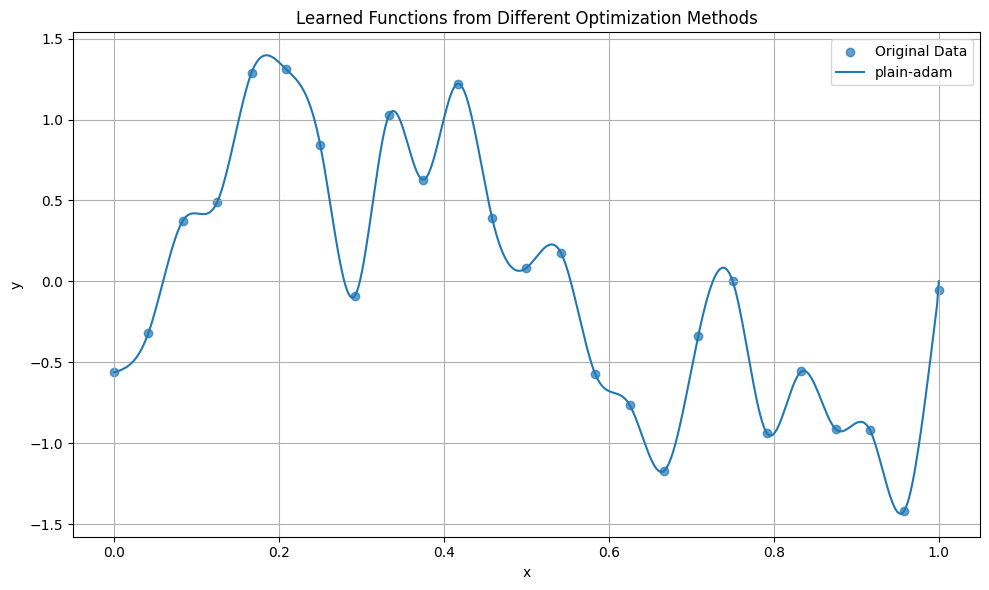

In [13]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=0.1, lr=1e-4, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1260e-01 | penalty 9.5182e-10
plain-adam | iter  200 | data 5.8700e-01 | penalty 3.5723e-05
plain-adam | iter  400 | data 5.6230e-01 | penalty 1.3924e-04
plain-adam | iter  600 | data 5.3858e-01 | penalty 3.0548e-04
plain-adam | iter  800 | data 5.1577e-01 | penalty 5.2983e-04
plain-adam | iter 1000 | data 4.9382e-01 | penalty 8.0826e-04
plain-adam | iter 1200 | data 4.7268e-01 | penalty 1.1374e-03
plain-adam | iter 1400 | data 4.5230e-01 | penalty 1.5146e-03
plain-adam | iter 1600 | data 4.3266e-01 | penalty 1.9378e-03
plain-adam | iter 1800 | data 4.1372e-01 | penalty 2.4051e-03
plain-adam | iter 2000 | data 3.9545e-01 | penalty 2.9152e-03
plain-adam | iter 2200 | data 3.7783e-01 | penalty 3.4665e-03
plain-adam | iter 2400 | data 3.6083e-01 | penalty 4.0574e-03
plain-adam | iter 2600 | data 3.4443e-01 | penalty 4.6865e-03
plain-adam | iter 2800 | data 3.2861e-01 | penalty 5.3521e-03
plain-adam | iter 3000 | data 3.1335e-01 | penalty

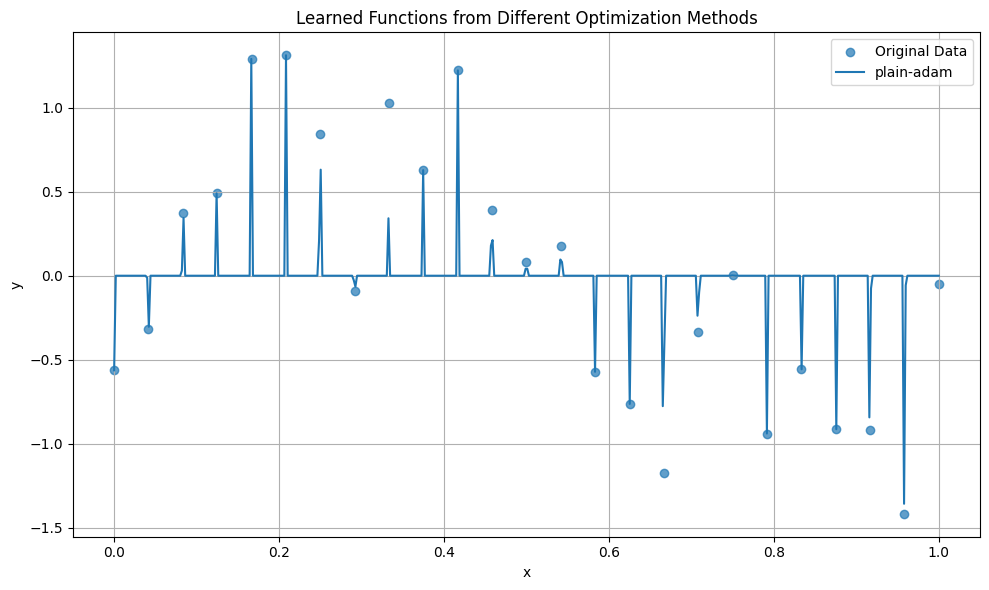

In [14]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=0.0, lr=1e-4, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1260e-01 | penalty 9.5182e-10
plain-adam | iter  200 | data 5.8700e-01 | penalty 4.2254e-06
plain-adam | iter  400 | data 5.6230e-01 | penalty 1.0153e-05
plain-adam | iter  600 | data 5.3858e-01 | penalty 1.6690e-05
plain-adam | iter  800 | data 5.1577e-01 | penalty 2.3532e-05
plain-adam | iter 1000 | data 4.9382e-01 | penalty 3.0542e-05
plain-adam | iter 1200 | data 4.7268e-01 | penalty 3.7652e-05
plain-adam | iter 1400 | data 4.5230e-01 | penalty 4.4830e-05
plain-adam | iter 1600 | data 4.3266e-01 | penalty 5.2056e-05
plain-adam | iter 1800 | data 4.1372e-01 | penalty 5.9316e-05
plain-adam | iter 2000 | data 3.9545e-01 | penalty 6.6591e-05
plain-adam | iter 2200 | data 3.7783e-01 | penalty 7.3865e-05
plain-adam | iter 2400 | data 3.6083e-01 | penalty 8.1121e-05
plain-adam | iter 2600 | data 3.4443e-01 | penalty 8.8342e-05
plain-adam | iter 2800 | data 3.2861e-01 | penalty 9.5516e-05
plain-adam | iter 3000 | data 3.1335e-01 | penalty

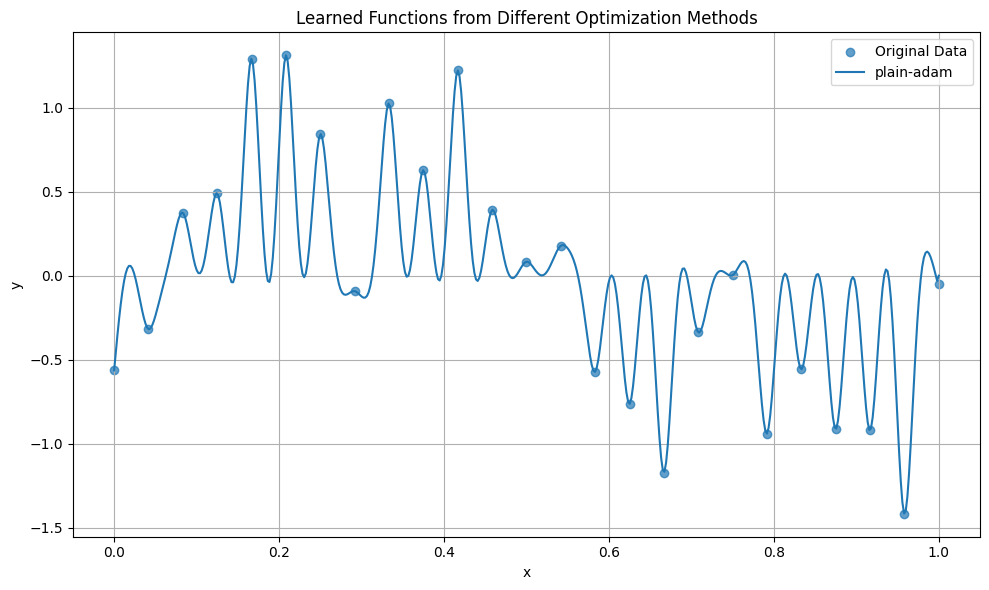

In [15]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=0.001, lr=1e-4, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1260e-01 | penalty 9.5182e-10
plain-adam | iter  200 | data 5.8700e-01 | penalty 9.1271e-07
plain-adam | iter  400 | data 5.6230e-01 | penalty 2.0693e-06
plain-adam | iter  600 | data 5.3858e-01 | penalty 3.3142e-06
plain-adam | iter  800 | data 5.1577e-01 | penalty 4.6058e-06
plain-adam | iter 1000 | data 4.9382e-01 | penalty 5.9213e-06
plain-adam | iter 1200 | data 4.7268e-01 | penalty 7.2457e-06
plain-adam | iter 1400 | data 4.5230e-01 | penalty 8.5700e-06
plain-adam | iter 1600 | data 4.3266e-01 | penalty 9.8889e-06
plain-adam | iter 1800 | data 4.1372e-01 | penalty 1.1199e-05
plain-adam | iter 2000 | data 3.9545e-01 | penalty 1.2498e-05
plain-adam | iter 2200 | data 3.7783e-01 | penalty 1.3784e-05
plain-adam | iter 2400 | data 3.6083e-01 | penalty 1.5056e-05
plain-adam | iter 2600 | data 3.4443e-01 | penalty 1.6312e-05
plain-adam | iter 2800 | data 3.2861e-01 | penalty 1.7552e-05
plain-adam | iter 3000 | data 3.1335e-01 | penalty

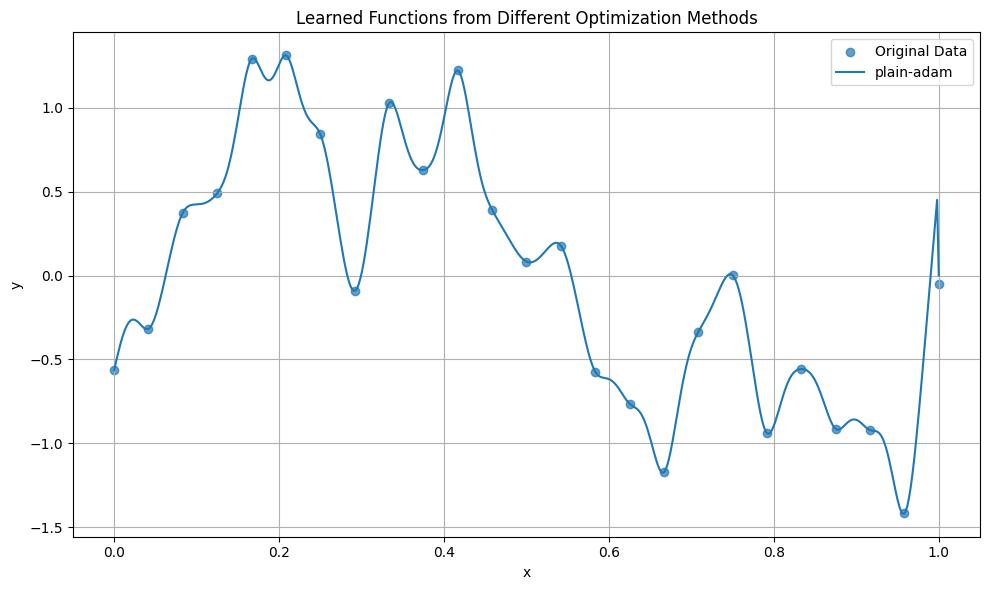

In [16]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=0.01, lr=1e-4, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1260e-01 | penalty 9.5182e-10
plain-adam | iter  200 | data 5.8700e-01 | penalty 1.9988e-07
plain-adam | iter  400 | data 5.6230e-01 | penalty 4.1479e-07
plain-adam | iter  600 | data 5.3858e-01 | penalty 6.4002e-07
plain-adam | iter  800 | data 5.1577e-01 | penalty 8.8283e-07
plain-adam | iter 1000 | data 4.9382e-01 | penalty 1.1433e-06
plain-adam | iter 1200 | data 4.7268e-01 | penalty 1.4190e-06
plain-adam | iter 1400 | data 4.5230e-01 | penalty 1.7073e-06
plain-adam | iter 1600 | data 4.3266e-01 | penalty 2.0053e-06
plain-adam | iter 1800 | data 4.1372e-01 | penalty 2.3105e-06
plain-adam | iter 2000 | data 3.9545e-01 | penalty 2.6208e-06
plain-adam | iter 2200 | data 3.7783e-01 | penalty 2.9343e-06
plain-adam | iter 2400 | data 3.6083e-01 | penalty 3.2495e-06
plain-adam | iter 2600 | data 3.4443e-01 | penalty 3.5651e-06
plain-adam | iter 2800 | data 3.2861e-01 | penalty 3.8801e-06
plain-adam | iter 3000 | data 3.1335e-01 | penalty

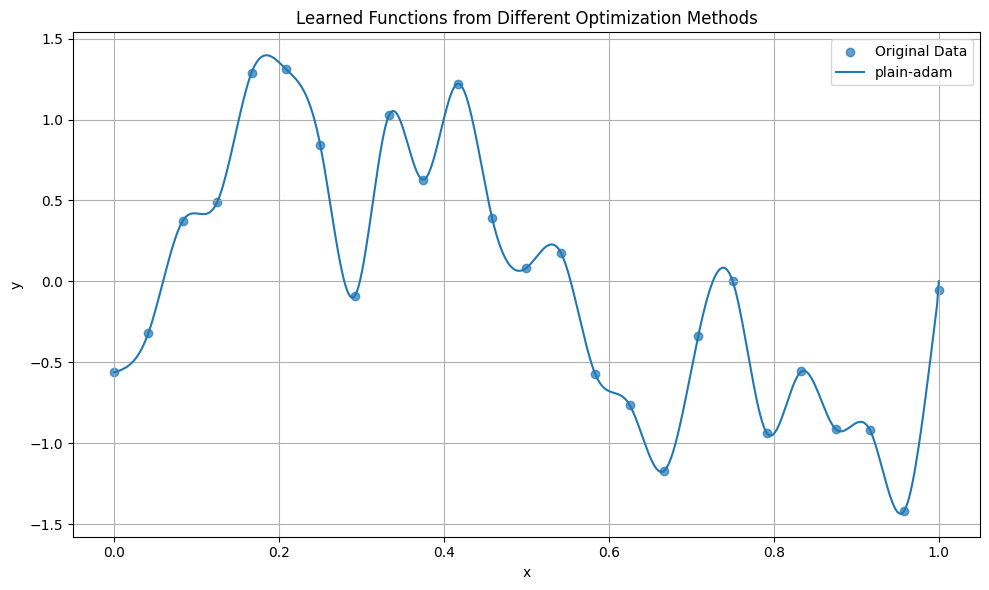

In [17]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=0.1, lr=1e-4, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1260e-01 | penalty 9.5182e-10
plain-adam | iter  200 | data 5.8700e-01 | penalty 1.4318e-07
plain-adam | iter  400 | data 5.6230e-01 | penalty 2.5475e-07
plain-adam | iter  600 | data 5.3858e-01 | penalty 3.8651e-07
plain-adam | iter  800 | data 5.1577e-01 | penalty 5.3703e-07
plain-adam | iter 1000 | data 4.9382e-01 | penalty 7.0135e-07
plain-adam | iter 1200 | data 4.7268e-01 | penalty 8.7438e-07
plain-adam | iter 1400 | data 4.5230e-01 | penalty 1.0514e-06
plain-adam | iter 1600 | data 4.3266e-01 | penalty 1.2288e-06
plain-adam | iter 1800 | data 4.1372e-01 | penalty 1.4046e-06
plain-adam | iter 2000 | data 3.9545e-01 | penalty 1.5751e-06
plain-adam | iter 2200 | data 3.7783e-01 | penalty 1.7390e-06
plain-adam | iter 2400 | data 3.6083e-01 | penalty 1.8954e-06
plain-adam | iter 2600 | data 3.4443e-01 | penalty 2.0426e-06
plain-adam | iter 2800 | data 3.2861e-01 | penalty 2.1807e-06
plain-adam | iter 3000 | data 3.1335e-01 | penalty

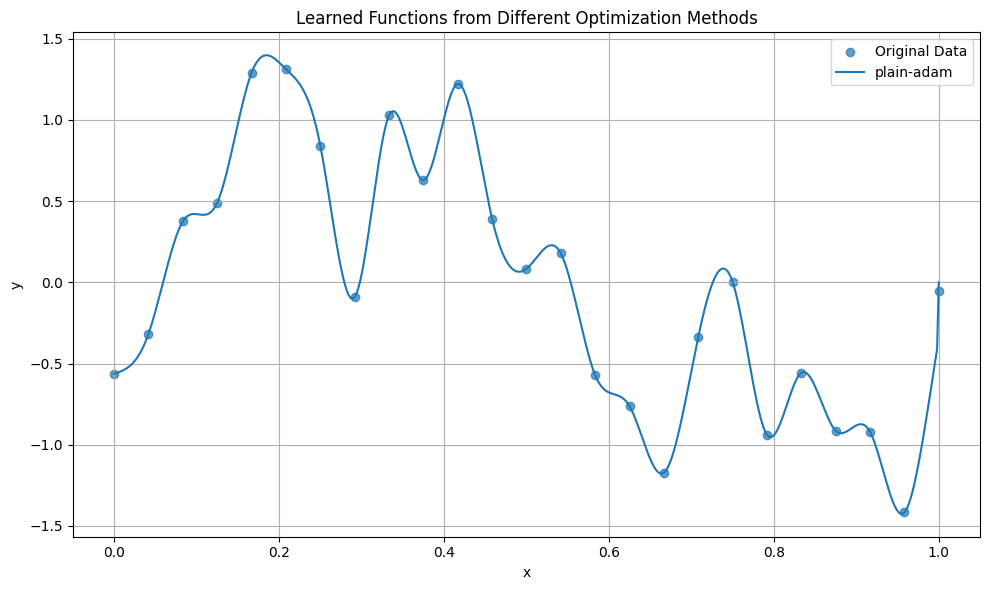

In [18]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=1.0, lr=1e-4, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1260e-01 | penalty 9.5182e-10
plain-adam | iter  200 | data 5.8700e-01 | penalty 1.4159e-07
plain-adam | iter  400 | data 5.6231e-01 | penalty 2.4669e-07
plain-adam | iter  600 | data 5.3858e-01 | penalty 3.7565e-07
plain-adam | iter  800 | data 5.1577e-01 | penalty 5.2343e-07
plain-adam | iter 1000 | data 4.9382e-01 | penalty 6.8565e-07
plain-adam | iter 1200 | data 4.7268e-01 | penalty 8.5595e-07
plain-adam | iter 1400 | data 4.5231e-01 | penalty 1.0305e-06
plain-adam | iter 1600 | data 4.3267e-01 | penalty 1.2057e-06
plain-adam | iter 1800 | data 4.1373e-01 | penalty 1.3787e-06
plain-adam | iter 2000 | data 3.9546e-01 | penalty 1.5471e-06
plain-adam | iter 2200 | data 3.7784e-01 | penalty 1.7091e-06
plain-adam | iter 2400 | data 3.6084e-01 | penalty 1.8634e-06
plain-adam | iter 2600 | data 3.4444e-01 | penalty 2.0093e-06
plain-adam | iter 2800 | data 3.2862e-01 | penalty 2.1460e-06
plain-adam | iter 3000 | data 3.1336e-01 | penalty

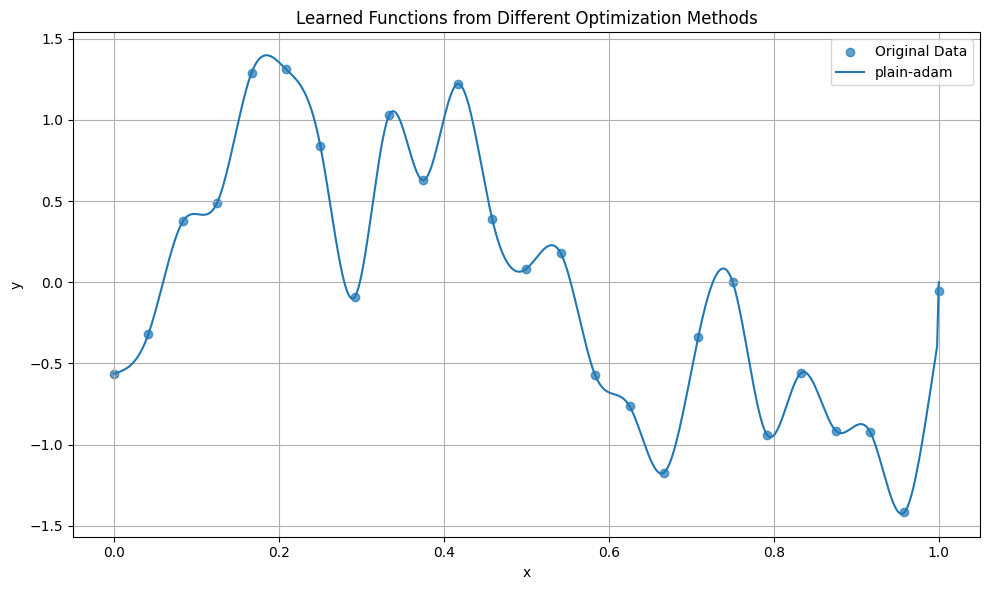

In [19]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=10.0, lr=1e-4, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1260e-01 | penalty 9.5182e-10
plain-adam | iter  200 | data 5.8701e-01 | penalty 1.4217e-07
plain-adam | iter  400 | data 5.6233e-01 | penalty 2.4677e-07
plain-adam | iter  600 | data 5.3861e-01 | penalty 3.7513e-07
plain-adam | iter  800 | data 5.1581e-01 | penalty 5.2210e-07
plain-adam | iter 1000 | data 4.9386e-01 | penalty 6.8440e-07
plain-adam | iter 1200 | data 4.7273e-01 | penalty 8.5428e-07
plain-adam | iter 1400 | data 4.5237e-01 | penalty 1.0278e-06
plain-adam | iter 1600 | data 4.3273e-01 | penalty 1.2019e-06
plain-adam | iter 1800 | data 4.1380e-01 | penalty 1.3736e-06
plain-adam | iter 2000 | data 3.9554e-01 | penalty 1.5410e-06
plain-adam | iter 2200 | data 3.7793e-01 | penalty 1.7024e-06
plain-adam | iter 2400 | data 3.6093e-01 | penalty 1.8564e-06
plain-adam | iter 2600 | data 3.4454e-01 | penalty 2.0024e-06
plain-adam | iter 2800 | data 3.2873e-01 | penalty 2.1393e-06
plain-adam | iter 3000 | data 3.1347e-01 | penalty

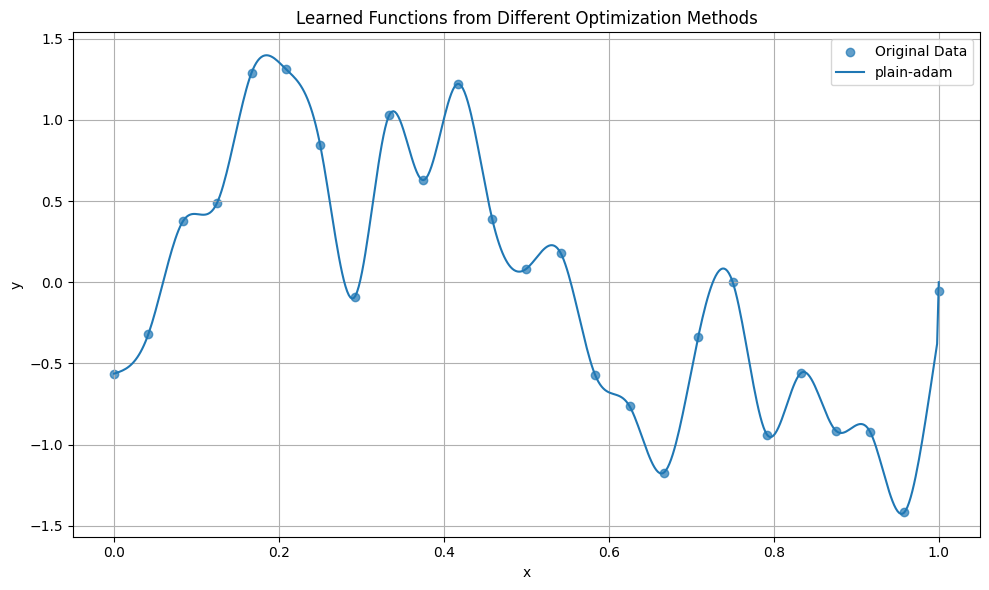

In [20]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=100.0, lr=1e-4, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1260e-01 | penalty 9.5182e-10
plain-adam | iter  200 | data 5.8830e-01 | penalty 1.1142e-07
plain-adam | iter  400 | data 5.6478e-01 | penalty 1.9458e-07
plain-adam | iter  600 | data 5.4202e-01 | penalty 3.0326e-07
plain-adam | iter  800 | data 5.2013e-01 | penalty 4.2957e-07
plain-adam | iter 1000 | data 4.9912e-01 | penalty 5.6852e-07
plain-adam | iter 1200 | data 4.7895e-01 | penalty 7.1275e-07
plain-adam | iter 1400 | data 4.5960e-01 | penalty 8.5811e-07
plain-adam | iter 1600 | data 4.4102e-01 | penalty 1.0016e-06
plain-adam | iter 1800 | data 4.2315e-01 | penalty 1.1402e-06
plain-adam | iter 2000 | data 4.0595e-01 | penalty 1.2722e-06
plain-adam | iter 2200 | data 3.8940e-01 | penalty 1.3972e-06
plain-adam | iter 2400 | data 3.7345e-01 | penalty 1.5140e-06
plain-adam | iter 2600 | data 3.5807e-01 | penalty 1.6216e-06
plain-adam | iter 2800 | data 3.4324e-01 | penalty 1.7210e-06
plain-adam | iter 3000 | data 3.2893e-01 | penalty

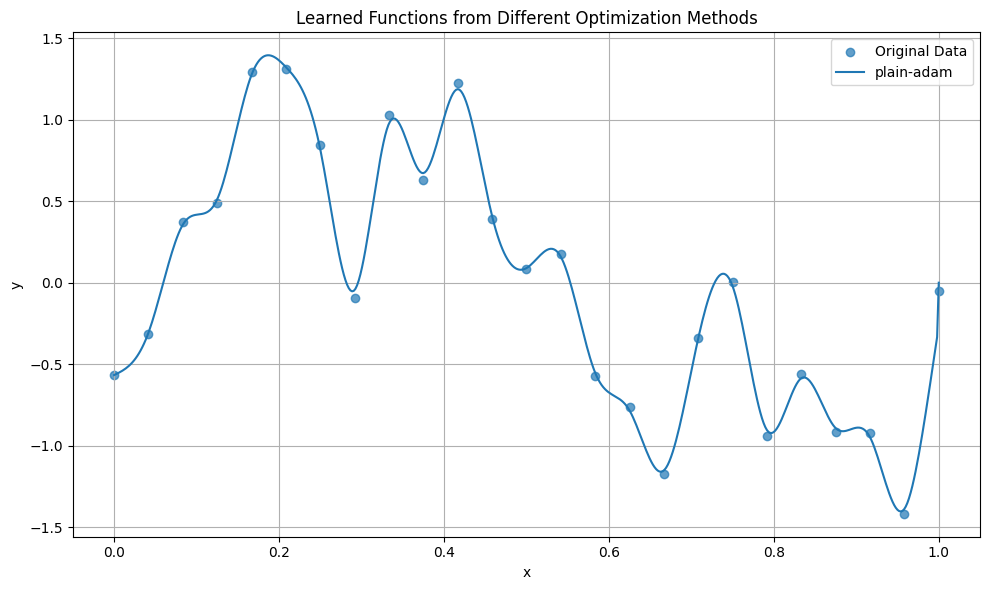

In [21]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=100.0 * 100.0, lr=1e-4, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1260e-01 | penalty 9.5182e-10
plain-adam | iter  200 | data 6.1149e-01 | penalty 2.1991e-10
plain-adam | iter  400 | data 6.1012e-01 | penalty 4.6713e-10
plain-adam | iter  600 | data 6.0883e-01 | penalty 7.4125e-10
plain-adam | iter  800 | data 6.0766e-01 | penalty 1.0363e-09
plain-adam | iter 1000 | data 6.0661e-01 | penalty 1.2430e-09
plain-adam | iter 1200 | data 6.0564e-01 | penalty 1.4762e-09
plain-adam | iter 1400 | data 6.0474e-01 | penalty 1.6539e-09
plain-adam | iter 1600 | data 6.0390e-01 | penalty 1.8435e-09
plain-adam | iter 1800 | data 6.0310e-01 | penalty 2.0579e-09
plain-adam | iter 2000 | data 6.0233e-01 | penalty 2.0937e-09
plain-adam | iter 2200 | data 6.0160e-01 | penalty 2.2755e-09
plain-adam | iter 2400 | data 6.0089e-01 | penalty 2.2642e-09
plain-adam | iter 2600 | data 6.0020e-01 | penalty 2.4165e-09
plain-adam | iter 2800 | data 5.9952e-01 | penalty 2.5246e-09
plain-adam | iter 3000 | data 5.9885e-01 | penalty

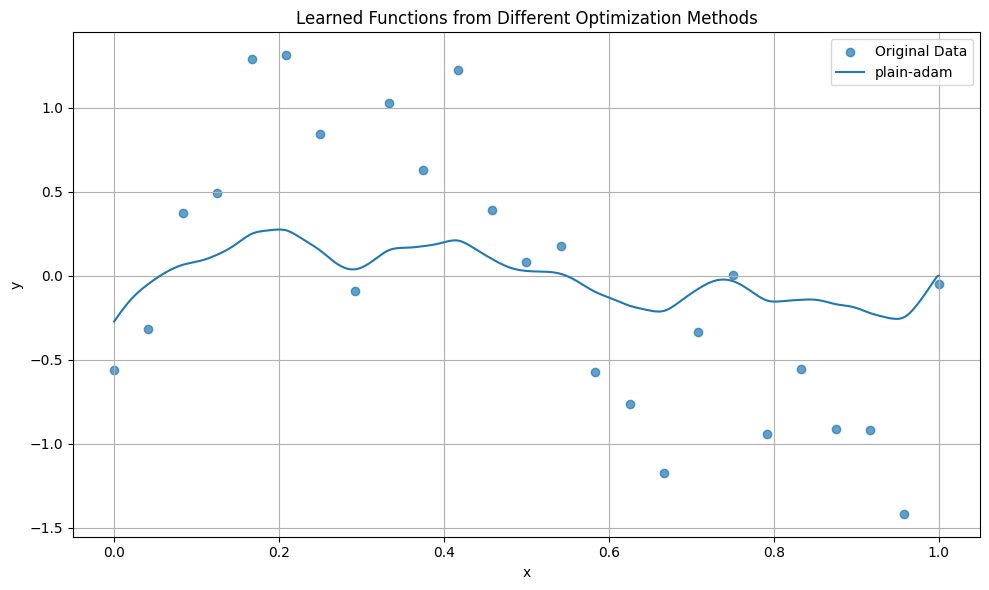

In [22]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=100.0 * 100.0 * 100.0, lr=1e-4, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1260e-01 | penalty 9.5182e-10
plain-adam | iter  200 | data 6.0115e-01 | penalty 1.8403e-08
plain-adam | iter  400 | data 5.8891e-01 | penalty 3.4857e-08
plain-adam | iter  600 | data 5.7714e-01 | penalty 5.6486e-08
plain-adam | iter  800 | data 5.6646e-01 | penalty 7.9538e-08
plain-adam | iter 1000 | data 5.5693e-01 | penalty 1.0095e-07
plain-adam | iter 1200 | data 5.4830e-01 | penalty 1.2027e-07
plain-adam | iter 1400 | data 5.4043e-01 | penalty 1.3683e-07
plain-adam | iter 1600 | data 5.3317e-01 | penalty 1.5095e-07
plain-adam | iter 1800 | data 5.2638e-01 | penalty 1.6286e-07
plain-adam | iter 2000 | data 5.2001e-01 | penalty 1.7273e-07
plain-adam | iter 2200 | data 5.1396e-01 | penalty 1.8102e-07
plain-adam | iter 2400 | data 5.0818e-01 | penalty 1.8797e-07
plain-adam | iter 2600 | data 5.0265e-01 | penalty 1.9354e-07
plain-adam | iter 2800 | data 4.9730e-01 | penalty 1.9841e-07
plain-adam | iter 3000 | data 4.9213e-01 | penalty

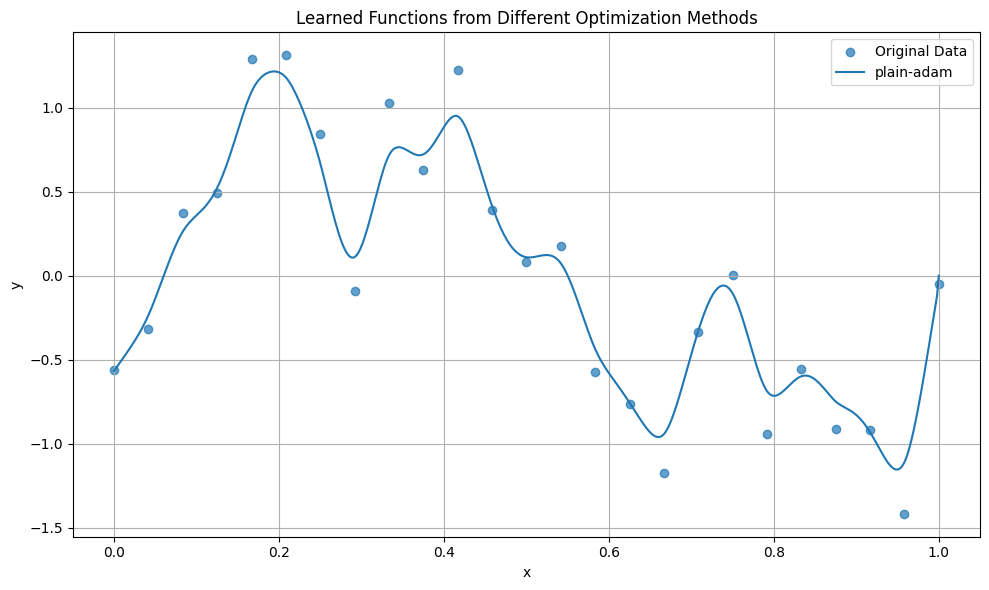

In [23]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=100.0 * 100.0 * 10.0, lr=1e-4, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1272e-01 | penalty 9.5182e-12
plain-adam | iter  200 | data 6.1025e-01 | penalty 1.1397e-09
plain-adam | iter  400 | data 6.0777e-01 | penalty 2.0405e-09
plain-adam | iter  600 | data 6.0530e-01 | penalty 3.2440e-09
plain-adam | iter  800 | data 6.0283e-01 | penalty 4.6718e-09
plain-adam | iter 1000 | data 6.0038e-01 | penalty 6.2819e-09
plain-adam | iter 1200 | data 5.9794e-01 | penalty 8.0127e-09
plain-adam | iter 1400 | data 5.9553e-01 | penalty 9.8149e-09
plain-adam | iter 1600 | data 5.9313e-01 | penalty 1.1649e-08
plain-adam | iter 1800 | data 5.9075e-01 | penalty 1.3494e-08
plain-adam | iter 2000 | data 5.8838e-01 | penalty 1.5332e-08
plain-adam | iter 2200 | data 5.8602e-01 | penalty 1.7153e-08
plain-adam | iter 2400 | data 5.8367e-01 | penalty 1.8943e-08
plain-adam | iter 2600 | data 5.8133e-01 | penalty 2.0704e-08
plain-adam | iter 2800 | data 5.7900e-01 | penalty 2.2415e-08
plain-adam | iter 3000 | data 5.7667e-01 | penalty

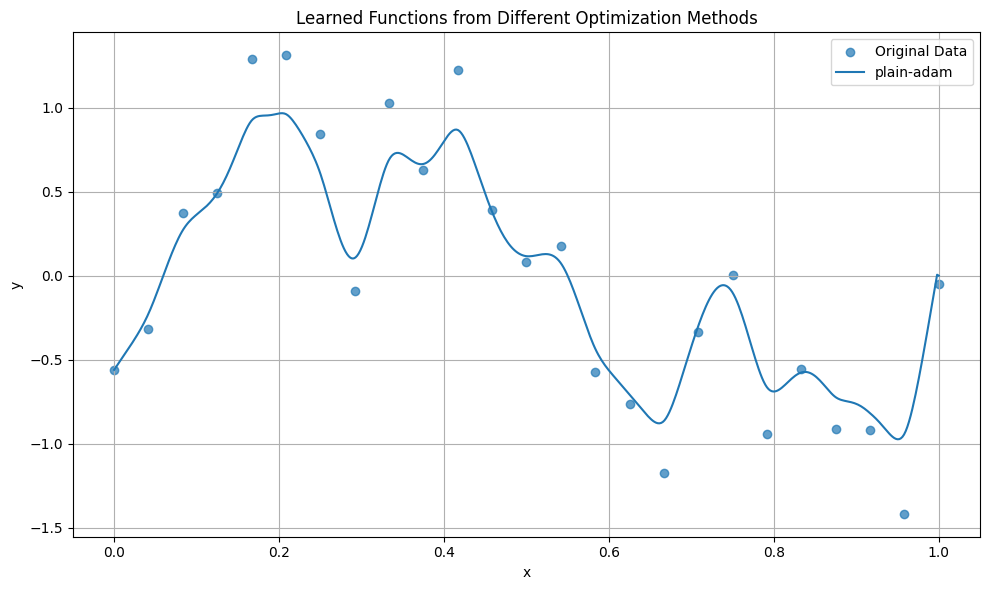

In [25]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000, lam=100.0 * 100.0 * 10.0, lr=1e-5, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1272e-01 | penalty 9.5182e-12
plain-adam | iter  200 | data 6.1025e-01 | penalty 1.1397e-09
plain-adam | iter  400 | data 6.0777e-01 | penalty 2.0405e-09
plain-adam | iter  600 | data 6.0530e-01 | penalty 3.2440e-09
plain-adam | iter  800 | data 6.0283e-01 | penalty 4.6718e-09
plain-adam | iter 1000 | data 6.0038e-01 | penalty 6.2819e-09
plain-adam | iter 1200 | data 5.9794e-01 | penalty 8.0127e-09
plain-adam | iter 1400 | data 5.9553e-01 | penalty 9.8149e-09
plain-adam | iter 1600 | data 5.9313e-01 | penalty 1.1649e-08
plain-adam | iter 1800 | data 5.9075e-01 | penalty 1.3494e-08
plain-adam | iter 2000 | data 5.8838e-01 | penalty 1.5332e-08
plain-adam | iter 2200 | data 5.8602e-01 | penalty 1.7153e-08
plain-adam | iter 2400 | data 5.8367e-01 | penalty 1.8943e-08
plain-adam | iter 2600 | data 5.8133e-01 | penalty 2.0704e-08
plain-adam | iter 2800 | data 5.7900e-01 | penalty 2.2415e-08
plain-adam | iter 3000 | data 5.7667e-01 | penalty

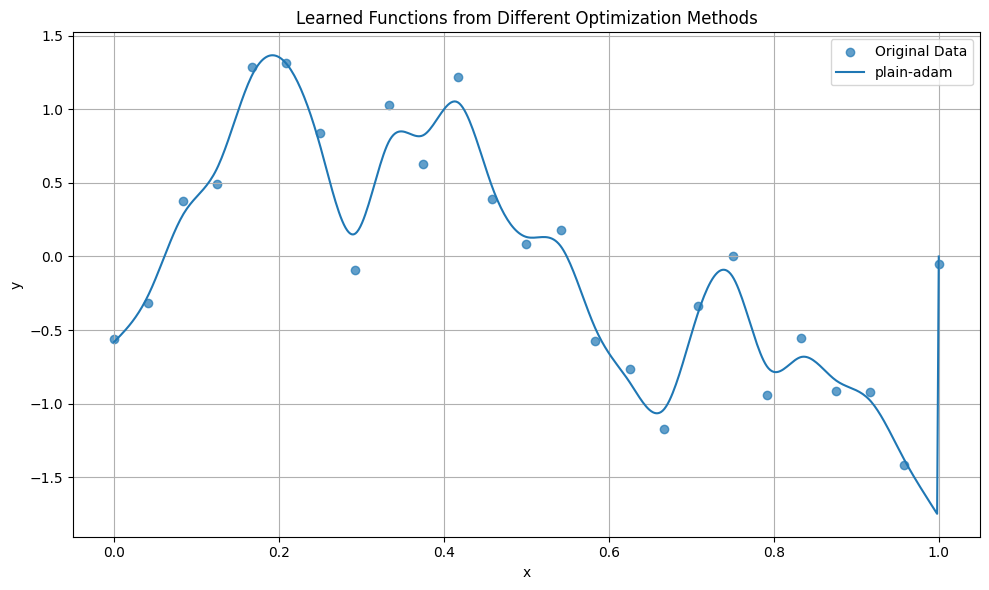

In [27]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000 * 10, lam=100.0 * 100.0 * 10.0, lr=1e-5, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()


In [29]:
import torch
import math
import matplotlib.pyplot as plt
import torch_dct as dct

torch.manual_seed(0)

# ----------------------------- toy data ---------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_data   = 25
x_data   = torch.linspace(0, 1, n_data, device=device)
y_data   = torch.sin(2 * math.pi * x_data) + 0.5 * torch.randn(n_data, device=device)

# ---------------------- B-spline basis (uniform) ------------------------
degree   = 1
n_coeffs = 1000
knots    = torch.linspace(0, 1, n_coeffs - degree + 1, device=device)
knots    = torch.cat([knots[:1].repeat(degree), knots, knots[-1:].repeat(degree)])

def bspline_basis(x, i, k, t):
    if k == 0:
        return ((t[i] <= x) & (x < t[i+1])).float()
    left  = 0 if t[i+k] == t[i]   else (x - t[i])     / (t[i+k]   - t[i])   * bspline_basis(x, i, k-1, t)
    right = 0 if t[i+k+1] == t[i+1] else (t[i+k+1] - x) / (t[i+k+1] - t[i+1]) * bspline_basis(x, i+1, k-1, t)
    return left + right

X = torch.stack([bspline_basis(x_data[:,None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

eye = torch.eye(n_coeffs, device=device)
D2  = eye[:-2] - 2*eye[1:-1] + eye[2:]

def losses(beta, lam):
    data_mse = ((X @ beta - y_data)**2).mean()
    rough    = (D2 @ beta).pow(2).mean()
    return data_mse, rough, data_mse + lam * rough

trained_betas = {}

def train(method, epochs=100000 * 100, lam=100.0 * 100.0 * 10.0, lr=1e-6, report_every=200):
    beta     = torch.zeros(n_coeffs, device=device, requires_grad=True)
    extras   = {}
    opt      = None

    if method == 'plain-adam':
        opt = torch.optim.Adam([beta], lr=lr)

    elif method == 'jacobi':
        H_diag = (X.T @ X) + lam * (D2.T @ D2)
        scale  = 1.0 / torch.sqrt(torch.diag(H_diag) + 1e-8)
        beta.data = beta.data * scale
        opt  = torch.optim.SGD([beta], lr=lr)
        extras['scale'] = scale

    elif method == 'adagrad':
        opt = torch.optim.Adagrad([beta], lr=lr)

        # J      = n_coeffs
        # freqs  = torch.arange(1, J - 1, device=device)
        # eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        # theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        # opt    = torch.optim.Adam([theta], lr=lr)
        # extras.update({'eigvals': eigvals, 'theta': theta})
    elif method == 'DR+adam':
        J      = n_coeffs
        freqs  = torch.arange(1, J - 1, device=device)
        eigvals = 4 * torch.sin(math.pi * freqs / (2 * (J - 1)))**4

        theta  = torch.zeros(J - 2, device=device, requires_grad=True)
        opt    = torch.optim.Adam([theta], lr=lr)
        extras.update({'eigvals': eigvals, 'theta': theta})

    elif method == 'prox-ista':
        opt = torch.optim.SGD([beta], lr=lr)
        LD   = torch.cholesky((torch.eye(n_coeffs, device=device) + lr * lam * (D2.T @ D2)))
        extras['LD'] = LD

    else:
        raise ValueError(method)

    for e in range(1, epochs+1):
        # if method == 'DR+adam':
        #     theta    = extras['theta']
        #     eigvals  = extras['eigvals']
        #     theta_scaled = theta / eigvals.sqrt()
        #     beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
        #     beta_curr = torch.fft.idct(beta_dct, type=2, norm='ortho')
        if method == 'DR+adam':
            theta    = extras['theta']
            eigvals  = extras['eigvals']
            theta_scaled = theta / eigvals.sqrt()
            beta_dct = torch.cat([torch.zeros(2, device=device), theta_scaled])
            beta_curr = dct.idct(beta_dct, norm='ortho')  # <- from torch_dct
        elif method == 'jacobi':
            beta_curr = beta / extras['scale']
        else:
            beta_curr = beta

        data_mse, rough, loss_total = losses(beta_curr, lam)
        if method == 'prox-ista':
            loss_total = data_mse

        opt.zero_grad()
        loss_total.backward()

        if method == 'prox-ista':
            with torch.no_grad():
                beta -= lr * beta.grad
                z = torch.cholesky_solve(beta.unsqueeze(1), extras['LD']).squeeze()
                beta.data.copy_(z)
        else:
            opt.step()

        if e % report_every == 0 or e == 1 or e == epochs:
            with torch.no_grad():
                data_mse, rough, _ = losses(beta_curr, lam)
                print(f'{method:10s} | iter {e:4d} | data {data_mse:.4e} | penalty {rough:.4e}')

    trained_betas[method] = beta_curr.detach().cpu()

for m in ['plain-adam']:
    print('\n===', m, '==='); train(m)

# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()



=== plain-adam ===
plain-adam | iter    1 | data 6.1273e-01 | penalty 9.5182e-14
plain-adam | iter  200 | data 6.1247e-01 | penalty 1.4370e-11
plain-adam | iter  400 | data 6.1221e-01 | penalty 2.5886e-11
plain-adam | iter  600 | data 6.1195e-01 | penalty 4.0656e-11
plain-adam | iter  800 | data 6.1169e-01 | penalty 5.8055e-11
plain-adam | iter 1000 | data 6.1143e-01 | penalty 7.7615e-11
plain-adam | iter 1200 | data 6.1117e-01 | penalty 9.8834e-11
plain-adam | iter 1400 | data 6.1091e-01 | penalty 1.2126e-10
plain-adam | iter 1600 | data 6.1065e-01 | penalty 1.4443e-10
plain-adam | iter 1800 | data 6.1039e-01 | penalty 1.6809e-10
plain-adam | iter 2000 | data 6.1013e-01 | penalty 1.9196e-10
plain-adam | iter 2200 | data 6.0987e-01 | penalty 2.1583e-10
plain-adam | iter 2400 | data 6.0961e-01 | penalty 2.3960e-10
plain-adam | iter 2600 | data 6.0935e-01 | penalty 2.6307e-10
plain-adam | iter 2800 | data 6.0909e-01 | penalty 2.8620e-10
plain-adam | iter 3000 | data 6.0883e-01 | penalty

KeyboardInterrupt: 

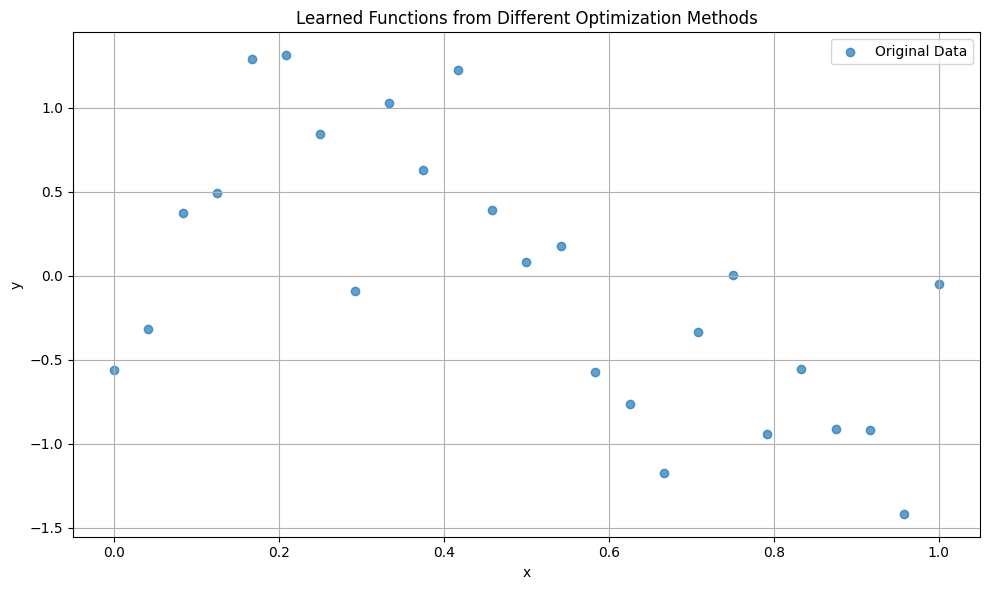

In [30]:
# ---------------------- Plotting ----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), label='Original Data', alpha=0.7)

x_plot = torch.linspace(0, 1, 500, device=device)
x_plot_np = x_plot.cpu().numpy()

X_plot = torch.stack([bspline_basis(x_plot[:, None], j, degree, knots) for j in range(n_coeffs)], dim=-1).squeeze().to(device)

for method, beta_val in trained_betas.items():
    y_learned = (X_plot @ beta_val.to(device)).cpu().numpy()
    plt.plot(x_plot_np, y_learned, label=f'{method}')

plt.title('Learned Functions from Different Optimization Methods')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learned_functions.png')
plt.show()
